In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/iris-segmentation/results/results/S1209R04.png
/kaggle/input/iris-segmentation/results/results/S1104L04.png
/kaggle/input/iris-segmentation/results/results/S1071R06.png
/kaggle/input/iris-segmentation/results/results/S1083L07.png
/kaggle/input/iris-segmentation/results/results/S1003R07.png
/kaggle/input/iris-segmentation/results/results/S1162R06.png
/kaggle/input/iris-segmentation/results/results/S1088R06.png
/kaggle/input/iris-segmentation/results/results/S1088R07.png
/kaggle/input/iris-segmentation/results/results/S1084R01.png
/kaggle/input/iris-segmentation/results/results/S1142R04.png
/kaggle/input/iris-segmentation/results/results/S1068L03.png
/kaggle/input/iris-segmentation/results/results/S1218R04.png
/kaggle/input/iris-segmentation/results/results/S1160R06.png
/kaggle/input/iris-segmentation/results/results/S1029R10.png
/kaggle/input/iris-segmentation/results/results/S1162L09.png
/kaggle/input/iris-segmentation/results/results/S1093R10.png
/kaggle/input/iris-segme

In [2]:
!pip install torchmetrics
!pip install segmentation_models_pytorch
!pip install albumentations

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 800.5 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... - \ done
  Preparing metadata (setup.py) ... - done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.5/68.5 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 13.7 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16428 sha256=490690bae397f0078869f757a23c2ab5e3429118f6f3651c5785a52d3bdf18a8
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60945 sha256=9cc6f19550b349ad288c1afc3cd72fe78d0ec71504577a36565e2427706650d0
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficie

In [3]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchmetrics
from torchmetrics import Dice, JaccardIndex
import segmentation_models_pytorch as smp
import albumentations as A
from albumentations.pytorch import ToTensorV2 # np.array -> torch.tensor
import os
from tqdm import tqdm
from glob import glob

In [4]:
print(A.__version__)

1.4.0


In [5]:
class IrisDataset(Dataset):
    def __init__(self, root_dir, ROI_input, results, transform=None):
        self.root_dir = root_dir
        self.ROI_input = ROI_input
        self.results = results
        self.transform = transform
        self.img_path_lst = []
        # Lấy danh sách các tệp hình ảnh từ thư mục ROI_input
        img_files = [f for f in os.listdir(self.ROI_input) if f.endswith(".jpg")]
        for filename in img_files:
            self.img_path_lst.append(filename)  # Thêm tên file vào danh sách

    def __len__(self):
        return len(self.img_path_lst)

    def __getitem__(self, idx):
        # Xây dựng đường dẫn đầy đủ đến hình ảnh và mặt nạ
        image_path = os.path.join(self.ROI_input, self.img_path_lst[idx])
        mask_path = os.path.join(self.results, self.img_path_lst[idx].replace(".jpg", ".png"))

        # Đọc hình ảnh và mặt nạ từ đường dẫn
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        if mask is None:  # Kiểm tra xem mask có bị None hay không
          mask = np.zeros_like(image[..., 0])  # Tạo mặt nạ trống
        else:
          mask = mask.astype('uint8')  # Chuyển đổi kiểu dữ liệu sang uint8

        # Chuyển các giá trị mặt nạ 255 thành 1
        mask[mask >= 200] = 1

        # Áp dụng biến đổi nếu có
        if self.transform is not None:
            transformed = self.transform(image=image, mask=mask)
            transformed_image = transformed['image']
            transformed_mask = transformed['mask']
            return transformed_image, transformed_mask
        else:
            return image, mask

In [6]:
trainsize = 384

train_transform = A.Compose([
    A.Resize(width=trainsize, height=trainsize),
    A.HorizontalFlip(),
    A.RandomBrightnessContrast(),
    A.Blur(),
    A.Sharpen(),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0),
    ToTensorV2(),
])

test_trainsform = A.Compose([
    A.Resize(width=trainsize, height=trainsize),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0),
    ToTensorV2(), # numpy.array -> torch.tensor (B, 3, H, W)
])

In [7]:
class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
            # The normalize code -> t.sub_(m).div_(s)
        return tensor

unorm = UnNormalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))

In [8]:
 train_dataset = IrisDataset("/kaggle/input/iris-segmentation", "/kaggle/input/iris-segmentation/data_iris/data_iris/train", "/kaggle/input/iris-segmentation/results/results", train_transform)
 test_dataset =  IrisDataset("/kaggle/input/iris-segmentation", "/kaggle/input/iris-segmentation/data_iris/data_iris/test", "/kaggle/input/iris-segmentation/results/results", test_trainsform)
# image, mask = train_dataset.__getitem__(10)
# plt.subplot(1, 2, 1)
# plt.imshow(unorm(image).permute(1, 2, 0))
# plt.subplot(1, 2, 2)
# plt.imshow(mask)
# plt.show

In [9]:
#model UNet
def unet_block(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, 1, 1),
        nn.ReLU(),
        nn.Conv2d(out_channels, out_channels, 3, 1, 1),
        nn.ReLU()
    )

class UNet(nn.Module):
    def __init__(self, n_classes):
        super().__init__()
        self.n_classes = n_classes
        self.downsample = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode="bilinear")
        self.block_down1 = unet_block(3, 64)
        self.block_down2 = unet_block(64, 128)
        self.block_down3 = unet_block(128, 256)
        self.block_down4 = unet_block(256, 512)
        self.block_neck = unet_block(512, 1024)
        self.block_up1 = unet_block(1024+512, 512)
        self.block_up2 = unet_block(256+512, 256)
        self.block_up3 = unet_block(128+256, 128)
        self.block_up4 = unet_block(128+64, 64)
        self.conv_cls = nn.Conv2d(64, self.n_classes, 1) # -> (B, n_class, H, W)

    def forward(self, x):
        # (B, C, H, W)
        x1 = self.block_down1(x)
        x = self.downsample(x1)
        x2 = self.block_down2(x)
        x = self.downsample(x2)
        x3 = self.block_down3(x)
        x = self.downsample(x3)
        x4 = self.block_down4(x)
        x = self.downsample(x4)

        x = self.block_neck(x)

        x = torch.cat([x4, self.upsample(x)], dim=1)
        x = self.block_up1(x)
        x = torch.cat([x3, self.upsample(x)], dim=1)
        x = self.block_up2(x)
        x = torch.cat([x2, self.upsample(x)], dim=1)
        x = self.block_up3(x)
        x = torch.cat([x1, self.upsample(x)], dim=1)
        x = self.block_up4(x)

        x = self.conv_cls(x)
        return x

# model = UNet(1)
# x = torch.rand(4, 3, trainsize, trainsize)
# print("Input shape =", x.shape)
# y = model(x).squeeze()
# print("Output shape = ", y.shape)
# # y true (4, 384, 384)
# # y hat.squeeze() (4, 1, 384, 384) -> (4, 384, 384)

In [10]:
class AverageMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [11]:
#accuracy fn
def accuracy_function(preds, targets):
    preds_flat = preds.flatten()
    targets_flat = targets.flatten()
    acc = torch.sum(preds_flat == targets_flat)
    return acc/targets_flat.shape[0]

In [12]:
#device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#load data
batch_size = 8
n_workers = os.cpu_count()
print("num_workers =", n_workers)
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                          shuffle=True, num_workers=n_workers)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                          shuffle=False, num_workers=n_workers)

#model
model = UNet(1).to(device)

#loss
criterion = nn.BCEWithLogitsLoss()

#optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
n_eps = 30

#metrics
dice_fn = torchmetrics.Dice(num_classes=2, average="macro").to(device)
iou_fn = torchmetrics.JaccardIndex(num_classes=2, task="binary", average="macro").to(device)

#meter
acc_meter = AverageMeter()
train_loss_meter = AverageMeter()
dice_meter = AverageMeter()
iou_meter = AverageMeter()

num_workers = 4


In [13]:
# Kiểm tra xem có nhiều hơn 1 GPU hay không
if torch.cuda.device_count() > 1:
    print("Let's use", torch.cuda.device_count(), "GPUs!")
    model = nn.DataParallel(model)

model = model.to(device)

for ep in range(1, 1+n_eps):
    acc_meter.reset()
    train_loss_meter.reset()
    dice_meter.reset()
    iou_meter.reset()
    model.train()

    for batch_id, (x, y) in enumerate(tqdm(trainloader), start=1):
        optimizer.zero_grad()
        n = x.shape[0]
        x = x.to(device).float()
        y = y.to(device).float()
        y_hat = model(x)
        y_hat = y_hat.squeeze() # -> logit (-vc, +vc)
        loss = criterion(y_hat, y)
        loss.backward()
        optimizer.step()

        with torch.no_grad():
            y_hat_mask = y_hat.sigmoid().round().long() # -> mask (0, 1)
            dice_score = dice_fn(y_hat_mask, y.long())
            iou_score = iou_fn(y_hat_mask, y.long())
            accuracy = accuracy_function(y_hat_mask, y.long())

            train_loss_meter.update(loss.item(), n)
            iou_meter.update(iou_score.item(), n)
            dice_meter.update(dice_score.item(), n)
            acc_meter.update(accuracy.item(), n)

    print("EP {}, train loss = {}, accuracy = {}, IoU = {}, dice = {}".format(
        ep, train_loss_meter.avg, acc_meter.avg, iou_meter.avg, dice_meter.avg
    ))
    if ep >= 25:
        torch.save(model.module.state_dict(), "/kaggle/working/model_ep_{}.pth".format(ep))  # Lưu trữ state_dict của mô hình, không phải của DataParallel


Let's use 2 GPUs!


100%|██████████| 264/264 [02:33<00:00,  1.72it/s]


EP 1, train loss = 0.4329407850467729, accuracy = 0.7786560421650505, IoU = 0.31821615625286426, dice = 0.63038333611425


100%|██████████| 264/264 [02:34<00:00,  1.71it/s]


EP 2, train loss = 0.1018923567625671, accuracy = 0.9597162104422047, IoU = 0.8654267936096698, dice = 0.9496132533509546


100%|██████████| 264/264 [02:34<00:00,  1.71it/s]


EP 3, train loss = 0.06365000886358392, accuracy = 0.9750841539317788, IoU = 0.9147953086831312, dice = 0.9690235622467533


100%|██████████| 264/264 [02:33<00:00,  1.72it/s]


EP 4, train loss = 0.05037244610785307, accuracy = 0.9804808169433695, IoU = 0.9326775879289891, dice = 0.9757735807257766


100%|██████████| 264/264 [02:33<00:00,  1.72it/s]


EP 5, train loss = 0.04712698839788645, accuracy = 0.981502171938062, IoU = 0.9360817101920126, dice = 0.9770369099937308


100%|██████████| 264/264 [02:33<00:00,  1.73it/s]


EP 6, train loss = 0.04443845157803123, accuracy = 0.9825754892893941, IoU = 0.9396417716648818, dice = 0.9783588797136774


100%|██████████| 264/264 [02:32<00:00,  1.73it/s]


EP 7, train loss = 0.04288282490687081, accuracy = 0.9832576923849913, IoU = 0.9419653864694049, dice = 0.9792130088444226


100%|██████████| 264/264 [02:32<00:00,  1.73it/s]


EP 8, train loss = 0.04614939930825804, accuracy = 0.9818873671245756, IoU = 0.9375148360145612, dice = 0.9775385294512507


100%|██████████| 264/264 [02:32<00:00,  1.73it/s]


EP 9, train loss = 0.04161312739299416, accuracy = 0.983533839460116, IoU = 0.9429830321777025, dice = 0.9795779749835918


100%|██████████| 264/264 [02:32<00:00,  1.73it/s]


EP 10, train loss = 0.04081598728668984, accuracy = 0.983996756728279, IoU = 0.9445160881844146, dice = 0.9801478076026381


100%|██████████| 264/264 [02:32<00:00,  1.74it/s]


EP 11, train loss = 0.040074568227696915, accuracy = 0.9841171974701493, IoU = 0.9448942234439235, dice = 0.9802888895347855


100%|██████████| 264/264 [02:32<00:00,  1.74it/s]


EP 12, train loss = 0.039474013323349565, accuracy = 0.9844246097262489, IoU = 0.945985622039556, dice = 0.980682200566641


100%|██████████| 264/264 [02:32<00:00,  1.74it/s]


EP 13, train loss = 0.03943368034751863, accuracy = 0.9843742779581551, IoU = 0.9457364432951983, dice = 0.9805984320631516


100%|██████████| 264/264 [02:31<00:00,  1.74it/s]


EP 14, train loss = 0.043485165469390845, accuracy = 0.9830894898870638, IoU = 0.9415385701624673, dice = 0.9790297855236046


100%|██████████| 264/264 [02:31<00:00,  1.74it/s]


EP 15, train loss = 0.03928289951251173, accuracy = 0.9846173615338002, IoU = 0.9465843346358703, dice = 0.9809094966023425


100%|██████████| 264/264 [02:32<00:00,  1.73it/s]


EP 16, train loss = 0.03777124791757771, accuracy = 0.9849360026489852, IoU = 0.9477344724213602, dice = 0.9813227017871343


100%|██████████| 264/264 [02:32<00:00,  1.74it/s]


EP 17, train loss = 0.03812204449096486, accuracy = 0.9848591533738703, IoU = 0.9474351081495267, dice = 0.981216912251496


100%|██████████| 264/264 [02:32<00:00,  1.74it/s]


EP 18, train loss = 0.03898963585948356, accuracy = 0.9846830612341865, IoU = 0.9469112949534204, dice = 0.9810129958266778


100%|██████████| 264/264 [02:31<00:00,  1.74it/s]


EP 19, train loss = 0.038925945263999236, accuracy = 0.9846071674430167, IoU = 0.9466016959872599, dice = 0.9809044970506962


100%|██████████| 264/264 [02:32<00:00,  1.74it/s]


EP 20, train loss = 0.036975878741472, accuracy = 0.985235201339794, IoU = 0.948743004726504, dice = 0.9816858431419793


100%|██████████| 264/264 [02:31<00:00,  1.74it/s]


EP 21, train loss = 0.03777063302554374, accuracy = 0.9851314165334322, IoU = 0.9484238682254669, dice = 0.9815706473826458


100%|██████████| 264/264 [02:31<00:00,  1.74it/s]


EP 22, train loss = 0.03755470243701446, accuracy = 0.985098996130746, IoU = 0.9482483087952268, dice = 0.98151270510802


100%|██████████| 264/264 [02:31<00:00,  1.74it/s]


EP 23, train loss = 0.03701302326819815, accuracy = 0.9853119052791053, IoU = 0.9490247892473861, dice = 0.9817930603615473


100%|██████████| 264/264 [02:31<00:00,  1.74it/s]


EP 24, train loss = 0.038819189930946144, accuracy = 0.984632674724825, IoU = 0.946731363007873, dice = 0.9809486199827755


100%|██████████| 264/264 [02:31<00:00,  1.74it/s]


EP 25, train loss = 0.036978862861584895, accuracy = 0.9852408203499593, IoU = 0.9487505291625716, dice = 0.981696625362085


100%|██████████| 264/264 [02:31<00:00,  1.74it/s]


EP 26, train loss = 0.035656877215492204, accuracy = 0.9857775758973109, IoU = 0.950539433752563, dice = 0.9823561255348249


100%|██████████| 264/264 [02:31<00:00,  1.74it/s]


EP 27, train loss = 0.0353200018010058, accuracy = 0.9858132854132318, IoU = 0.9506795557897955, dice = 0.9824034762789674


100%|██████████| 264/264 [02:31<00:00,  1.75it/s]


EP 28, train loss = 0.0354698039662001, accuracy = 0.9858976768813956, IoU = 0.9509512028838923, dice = 0.9825040785139834


100%|██████████| 264/264 [02:31<00:00,  1.75it/s]


EP 29, train loss = 0.035263094655193915, accuracy = 0.9858914832010215, IoU = 0.9509623662570396, dice = 0.9825042131051167


100%|██████████| 264/264 [02:30<00:00,  1.75it/s]


EP 30, train loss = 0.03450524266915258, accuracy = 0.986203711444558, IoU = 0.9520104077328314, dice = 0.9828909676260469


In [14]:
model.eval()
test_iou_meter = AverageMeter()
test_dice_meter = AverageMeter()
with torch.no_grad():
    for batch_id, (x, y) in enumerate(tqdm(testloader), start=1):
        n = x.shape[0]
        x = x.to(device).float()
        y = y.to(device).float()
        y_hat = model(x)
        y_hat = y_hat.squeeze()
        y_hat_mask = y_hat.sigmoid().round().long()
        dice_score = dice_fn(y_hat_mask, y.long())
        iou_score = iou_fn(y_hat_mask, y.long())
        test_dice_meter.update(dice_score.item(), n)
        test_iou_meter.update(iou_score.item(), n)
print("TEST: IoU = {}, dice = {}".format(test_iou_meter.avg, test_dice_meter.avg))

100%|██████████| 50/50 [00:11<00:00,  4.45it/s]

TEST: IoU = 0.9518393080445785, dice = 0.9829043599623668


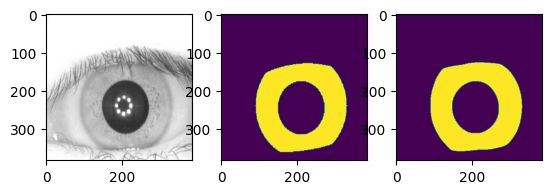

In [15]:
import random

model.eval()
idx = random.randint(0, 100)
with torch.no_grad():
    x, y = test_dataset[idx]
    # print(x.shape, y.shape) (C, H, W) -> (1, C, H, W) -> model
    x = x.to(device).float().unsqueeze(0)
    y_hat = model(x).squeeze() #(1, 1, H, W) -> (H, W)
    y_hat_mask = y_hat.sigmoid().round().long()
    # x, y, y_hat_mask
    plt.subplot(1, 3, 1)
    plt.imshow(unorm(x.squeeze().cpu()).permute(1, 2, 0)) # x (GPU) -> x(CPU)
    plt.subplot(1, 3, 2)
    plt.imshow(y)
    plt.subplot(1, 3, 3)
    plt.imshow(y_hat_mask.cpu())